Analyzing the paintings, part 3 to make the notebooks shorter.

In [1]:
%run ../scripts/notebook_settings_lean.py

/faststorage/project/baboondiversity/people/eriks/baboon_first_analysis/scripts/notebook_settings_lean.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', 'png')


In [2]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if hap == 1:
                hap = 2
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [3]:
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map = pd.read_csv(recomb_map_path.format("X", "X"), sep=" ")
pos_list = recomb_map["start.pos"]

In [4]:
chrom = "X"
population = "cyno_western"
recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
pos_list = recomb_map["start.pos"]
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
cyno_west = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                    "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                    .format(chrom, population, chrom, chrom)

#length_df = create_paint_df_lengths(cyno_west, idfile)

In [5]:
#window_df = length_to_windows(length_df.loc[(length_df.individual=="PD_0232")], window_size=100000)

In [6]:
#window_df

Converting every individual to the window_df structure

In [7]:
sorted(idfile.loc[idfile.inclusion == 1]["pop"].unique())

['anubis_ethiopia',
 'anubis_tanzania',
 'cyno_central',
 'cyno_western',
 'hamadryas',
 'kindae',
 'papio',
 'ursinus']

In [12]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = [] #["3", "8", "X"]
window_length = 100000
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in ['anubis_ethiopia','anubis_tanzania','cyno_central',
                       'cyno_western','hamadryas','kindae','papio','ursinus']:
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_"+ind+".txt"
            window_df = length_to_windows(length_df.loc[(length_df.individual==ind)], window_size=window_length)
            window_df.to_csv("../steps/paint_summary/"+name, sep=" ", index=False)

In [9]:
df_l = []
for population in ['anubis_tanzania','cyno_central']:
    for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
        name = population+"_chr"+chrom+"_8_cluster_"+ind+".txt"
        ind_df = pd.read_csv("../steps/paint_summary/"+name, sep=" ")
        ind_df["PGDP_ID"] = ind
        df_l.append(ind_df)
a_c_df = pd.concat(df_l)
a_c_df = a_c_df.replace(np.nan, 0)

In [10]:
a_c_df

,windows,anubis_ethiopia,cyno_central,cyno_western,hamadryas,kindae,papio,ursinus,PGDP_ID,anubis_tanzania
0,387,1707239.0,80019.0,3366.0,78199.0,59903.0,28928.0,42346.0,PD_0199,0.0
1,100387,1480531.0,24738.0,1118.0,578.0,7962.0,482162.0,2911.0,PD_0199,0.0
2,200387,1960970.0,2560.0,0.0,0.0,0.0,36470.0,0.0,PD_0199,0.0
3,300387,1983775.0,3680.0,670.0,0.0,2920.0,8735.0,220.0,PD_0199,0.0
4,400387,1970594.0,1633.0,11414.0,8085.0,0.0,7047.0,1227.0,PD_0199,0.0
...,...,...,...,...,...,...,...,...,...,...
1809,180900387,25613.0,0.0,535794.0,56709.0,296122.0,731.0,353107.0,PD_0774,731924.0
1810,181000387,17114.0,0.0,294353.0,74502.0,284035.0,10257.0,99108.0,PD_0774,1220631.0
1811,181100387,72253.0,0.0,329045.0,178149.0,416348.0,45385.0,112679.0,PD_0774,846141.0
1812,181200387,113957.0,0.0,33627.0,148162.0,627534.0,63801.0,312026.0,PD_0774,700893.0


[None, Text(0.5, 1.0, 'All West Cyno')]

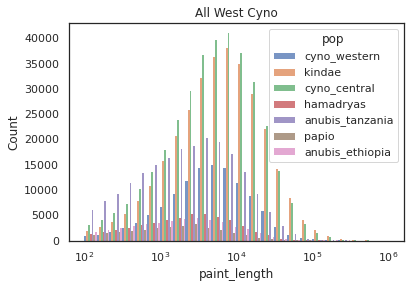

In [11]:
g = sns.histplot(length_df, x="paint_length", hue="pop", multiple="dodge",
                  bins=np.logspace(np.log10(100),np.log10(1000000), 25))
g.set(xscale="log", title="All West Cyno")